# DATA20001 Deep Learning - Group Project
## Image project

**Due Thursday, May 20, before 23:59.**

The task is to learn to assign the correct labels to a set of images.  The images are originally from a photo-sharing site and released under Creative Commons-licenses allowing sharing.  The training set contains 20 000 images. We have resized them and cropped them to 128x128 to make the task a bit more manageable.

We're only giving you the code for downloading the data. The rest you'll have to do yourselves.

Some comments and hints particular to the image project:

- One image may belong to many classes in this problem, i.e., it's a multi-label classification problem. In fact there are images that don't belong to any of our classes, and you should also be able to handle these correctly. Pay careful attention to how you design the outputs of the network (e.g., what activation to use) and what loss function should be used.

- As the dataset is pretty imbalanced, don't focus too strictly on the outputs being probabilistic. (Meaning that the right threshold for selecting the label might not be 0.5.)

- Image files can be loaded as numpy matrices for example using `imread` from `matplotlib.pyplot`. Most images are color, but a few grayscale. You need to handle the grayscale ones somehow as they would have a different number of color channels (depth) than the color ones.

- In the exercises we used e.g., `torchvision.datasets.MNIST` to handle the loading of the data in suitable batches. Here, you need to handle the dataloading yourself.  The easiest way is probably to create a custom `Dataset`. [See for example here for a tutorial](https://github.com/utkuozbulak/pytorch-custom-dataset-examples).

In [1]:
# automatically reload dependencies and repository content so that kernel need not be restarted
%load_ext autoreload
%autoreload 2

## Get the data

In [ ]:
import sys
import os
from os.path import join
from os.path import abspath
from os.path import split

import torch
import torchvision
from torchvision.datasets.utils import download_url
import zipfile

root_dir = os.getcwd()
if root_dir not in sys.path:
    sys.path.append(root_dir)
    
train_path = 'train'

data_folder_name = 'image-training-corpus+annotations'
DATA_FOLDER_DIR = os.path.abspath(os.path.join(root_dir, data_folder_name))

data_zip_name = 'dl2018-image-proj.zip'
DATA_ZIP_DIR = os.path.abspath(os.path.join(DATA_FOLDER_DIR, data_zip_name))

with zipfile.ZipFile(DATA_ZIP_DIR) as zip_f:
    zip_f.extractall(train_path)

The above command downloaded and extracted the data files into the `train` subdirectory.

The images can be found in `train/images`, and are named as `im1.jpg`, `im2.jpg` and so on until `im20000.jpg`.

The class labels, or annotations, can be found in `train/annotations` as `CLASSNAME.txt`, where CLASSNAME is one of the fourteen classes: *baby, bird, car, clouds, dog, female, flower, male, night, people, portrait, river, sea,* and *tree*.

Each annotation file is a simple text file that lists the images that depict that class, one per line. The images are listed with their number, not the full filename. For example `5969` refers to the image `im5969.jpg`.

## Your stuff goes here ...

In [5]:
import torch


device = None
if torch.cuda.is_available():
    print("Using GPU")
    device = torch.device("cuda:0")
else:
    print("Using CPU")
    device = torch.device("cpu")

Using GPU


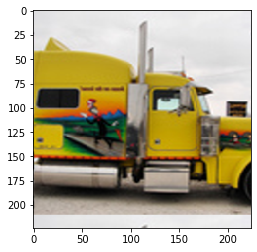

[]


In [6]:
from image_dataset import ImageDataset
from data_augmentation import DataAugmentation
import matplotlib.pyplot as plt
import random

dataAugmentation = DataAugmentation()
dataset = ImageDataset(dataAugmentation = dataAugmentation)
datum = dataset[random.randint(0, len(dataset)-1)]

plt.imshow(datum["imagePil"])
plt.show()

print(datum["labelsString"])

In [14]:
from torchvision import models
from train_model import train_model

trainDataset = ImageDataset(range(19000), dataAugmentation=dataAugmentation)
valDataset = ImageDataset(range(19000,20000))

preTrainedModel = models.resnext50_32x4d(pretrained=True)

for param in preTrainedModel.parameters():
    param.requires_grad = False

num_ftrs = preTrainedModel.fc.in_features
num_classes = 14

preTrainedModel.fc = torch.nn.Sequential(
    torch.nn.Linear(num_ftrs, num_classes),
    torch.nn.Sigmoid()
)

model = preTrainedModel.to(device)


model = train_model(
    model,
    trainDataset,
    valDataset,
    device,
    numberOfEpochs = 3
)

Epoch 1/3
----------
Training...

Progress: 0%
Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 70%
Progress: 80%
Progress: 90%
Progress: 100%

train Loss: 0.1551 Acc: 0.9442
Validating...

Progress: 0%
Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 70%
Progress: 80%
Progress: 90%
Progress: 100%

val Loss: 0.1200 Acc: 0.9554

Epoch 2/3
----------
Training...

Progress: 0%
Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 70%
Progress: 80%
Progress: 90%
Progress: 100%

train Loss: 0.1462 Acc: 0.9469
Validating...

Progress: 0%
Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 70%
Progress: 80%
Progress: 90%
Progress: 100%

val Loss: inf Acc: 0.9576

Epoch 3/3
----------
Training...

Progress: 0%
Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 70%
Progress: 80%
Prog

## Save your model

It might be useful to save your model if you want to continue your work later, or use it for inference later.

In [38]:
torch.save(model.state_dict(), 'transfer_model.pkl')

The model file should now be visible in the "Home" screen of the jupyter notebooks interface.  There you should be able to select it and press "download".  [See more here on how to load the model back](https://github.com/pytorch/pytorch/blob/761d6799beb3afa03657a71776412a2171ee7533/docs/source/notes/serialization.rst) if you want to continue training later.

## Download test set

The testset will be made available during the last week before the deadline and can be downloaded in the same way as the training set.

## Predict for test set

You should return your predictions for the test set in a plain text file.  The text file contains one row for each test set image.  Each row contains a binary prediction for each label (separated by a single space), 1 if it's present in the image, and 0 if not. The order of the labels is as follows (alphabetic order of the label names):

    baby bird car clouds dog female flower male night people portrait river sea tree

An example row could like like this if your system predicts the presense of a bird and clouds:

    0 1 0 1 0 0 0 0 0 0 0 0 0 0
    
The order of the rows should be according to the numeric order of the image numbers.  In the test set, this means that the first row refers to image `im20001.jpg`, the second to `im20002.jpg`, and so on.

If you have the prediction output matrix prepared in `y` you can use the following function to save it to a text file.

In [ ]:
np.savetxt('results.txt', y, fmt='%d')